### Imports

In [2]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
from datetime import datetime, timedelta
import json

# Future libraries:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

### Data collection
Use online resources to collect data that can convert CO2 to AQI values. AQI calculator exists online, however it is only limited to certain parameters. This will help create the logistic regression model

In [3]:
df = pd.read_csv('./Data/sample.log')

In [4]:
# New column headers
def parse_data(input_df, new_columns, date_experiment=(2024, 1, 1)):
    # Process
    first_row = input_df.columns
    first_row_df = first_row.to_frame().T.reset_index(drop=True)    
    input_df = pd.concat([first_row_df, input_df], ignore_index=True)
    input_df.columns = new_columns
    
    # Add a column of timestamps that are 15s intervals
    
    # Date experiment is given in year, month, day
    spacing = 15
    start_date = datetime(date_experiment[0], date_experiment[1], date_experiment[2])
    timestamps = [start_date + timedelta(seconds=i*spacing) for i in range(len(input_df))]   
    input_df.insert(loc=0, column='TimeStamp', value=timestamps)
    
    # Return
    return input_df 

In [5]:
# Creating new col names
gas_sensor = [f'GasSensor #{i} V' for i in range(1, 13)]
camera_pixels = [f'IRCamera Pixels #{i} ºC' for i in range(1, 65)]
# Combining names
new_columns = [
    *gas_sensor, 'Temperature ºC', 'Pressure Pa', 'Humidity %RH', 'Battery Charge %',
    'Net Current A', 'Tension V', 'Battery Temp ºC', 'PM 1.0 µg/m³', 'PM 2.5 µg/m³',
    'PM 4.0 µg/m³', 'PM 10.0 µg/m³', 'PM 1.0 1/cm³', 'PM 2.5 1/cm³', 'PM 4.0 1/cm³',
    'PM 10.0 1/cm³', 'PM Typ Size µm', 'CO2 ppm', 'Station ID', 'msg counter',
    *camera_pixels, 'Packt CheckSum'
]

df = parse_data(df, new_columns, (2024, 3, 11))

# Exploratory Data Analysis

### Visualizing data

In [6]:
df.head()

,TimeStamp,GasSensor #1 V,GasSensor #2 V,GasSensor #3 V,GasSensor #4 V,GasSensor #5 V,GasSensor #6 V,GasSensor #7 V,GasSensor #8 V,GasSensor #9 V,...,IRCamera Pixels #56 ºC,IRCamera Pixels #57 ºC,IRCamera Pixels #58 ºC,IRCamera Pixels #59 ºC,IRCamera Pixels #60 ºC,IRCamera Pixels #61 ºC,IRCamera Pixels #62 ºC,IRCamera Pixels #63 ºC,IRCamera Pixels #64 ºC,Packt CheckSum
0,2024-03-11 00:00:00,-0.567066,0.534685,0.429450,-0.335766,0.450423,-0.328523,0.493384,-0.206982,0.394445,...,14.26,15.28,15.29,15.30,15.31,15.32,14.27,14.28,14.29,215
1,2024-03-11 00:00:15,-0.567222,0.536036,0.429491,-0.335958,0.450594,-0.32862,0.493277,-0.206909,0.394705,...,14,14,15,15,15,15,15,14,13,146
2,2024-03-11 00:00:30,-0.566803,0.536476,0.429816,-0.33609,0.450983,-0.328509,0.493344,-0.207815,0.394276,...,14,15,15,15,15,15,15,15,14,211
3,2024-03-11 00:00:45,-0.567058,0.53642,0.429712,-0.336016,0.450695,-0.328626,0.493615,-0.206926,0.393988,...,14,15,15,15,15,15,15,14,13,143
4,2024-03-11 00:01:00,-0.56683,0.536593,0.429909,-0.336115,0.451058,-0.328863,0.493175,-0.207109,0.394895,...,14,15,15,15,15,15,15,14,14,181


In [7]:
df.tail()

,TimeStamp,GasSensor #1 V,GasSensor #2 V,GasSensor #3 V,GasSensor #4 V,GasSensor #5 V,GasSensor #6 V,GasSensor #7 V,GasSensor #8 V,GasSensor #9 V,...,IRCamera Pixels #56 ºC,IRCamera Pixels #57 ºC,IRCamera Pixels #58 ºC,IRCamera Pixels #59 ºC,IRCamera Pixels #60 ºC,IRCamera Pixels #61 ºC,IRCamera Pixels #62 ºC,IRCamera Pixels #63 ºC,IRCamera Pixels #64 ºC,Packt CheckSum
67,2024-03-11 00:16:45,-0.567766,0.539755,0.431691,-0.337616,0.449515,-0.328548,0.493154,-0.210064,0.393266,...,12,13,14,14,14,14,14,14,12,198
68,2024-03-11 00:17:00,-0.5681,0.538896,0.431838,-0.33757,0.448723,-0.32842,0.492898,-0.210132,0.393935,...,13,14,14,14,14,14,14,13,12,158
69,2024-03-11 00:17:15,-0.567998,0.539165,0.431963,-0.337678,0.449463,-0.328302,0.492827,-0.208606,0.394298,...,13,14,14,14,14,14,14,14,12,55
70,2024-03-11 00:17:30,-0.56788,0.538843,0.431898,-0.337753,0.449489,-0.32827,0.493254,-0.209786,0.394309,...,14,14,14,14,14,14,14,14,12,221
71,2024-03-11 00:17:45,-0.568068,0.538909,0.431856,-0.337945,0.44973,-0.328652,0.492734,-0.211188,0.394326,...,13,14,14,14,14,14,14,13,12,142


In [8]:
df.iloc[:, 1:].describe().transpose()

,count,unique,top,freq
GasSensor #1 V,72.0,71.0,-0.567712,2.0
GasSensor #2 V,72,72,0.534685,1
GasSensor #3 V,72,72,0.429450,1
GasSensor #4 V,72.0,71.0,-0.33757,2.0
GasSensor #5 V,72.0,71.0,0.449436,2.0
...,...,...,...,...
IRCamera Pixels #61 ºC,72,4,14,51
IRCamera Pixels #62 ºC,72,4,14,55
IRCamera Pixels #63 ºC,72,4,14,46
IRCamera Pixels #64 ºC,72,4,13,32


In [9]:
df.shape

(72, 97)

### Visualizations

In [10]:
# Expected that values contains the values you want to compare w.r.t time
# Time is every 15 second intervals
# The end value is exclusive
def plot_time_series(timestamps, values, start=0, end=len(df), y_label = '', title='', width=0.5):
    # Extract time stamps
    temp_times = pd.to_datetime(timestamps)[start:end]
    values = values[start:end]
    if not all(isinstance(v, str) for v in values):
        values = values.astype(str)
    
    plt.figure(figsize=[15, 10])
    plt.plot(temp_times, values, label=y_label, linewidth=width)

    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Show all ticks
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S')) # Formatting
    plt.xticks(rotation=60)
    
    plt.title(title)
    plt.xlabel('Time[s]')
    plt.ylabel(y_label)    
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [11]:
def display_time_series(df, start=0, end=len(df), width=0.5, features=df.columns[1:]):
    timestamps = df['TimeStamp']
    titles = {column: f'{column} vs Time' for column in new_columns if column != 'Station ID'}
    
    for column in features:
        if column != 'Station ID':
            values = df[column]
            title = titles.get(column, column) if titles else column
            plot_time_series(timestamps, values, start, end, y_label=column, title=title, width=width)

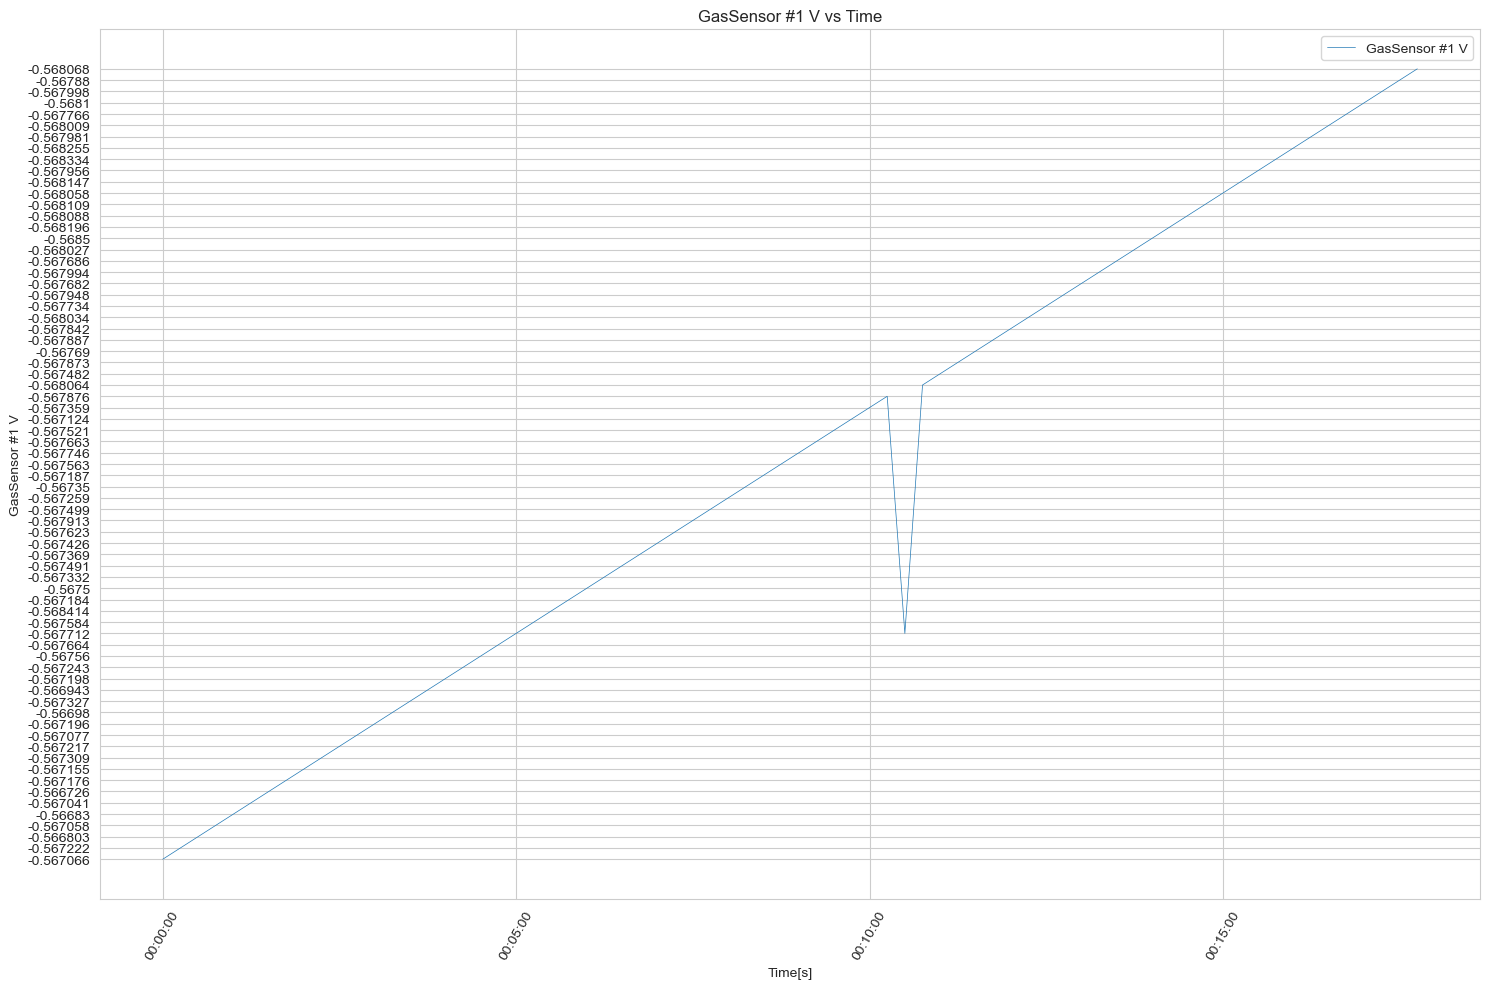

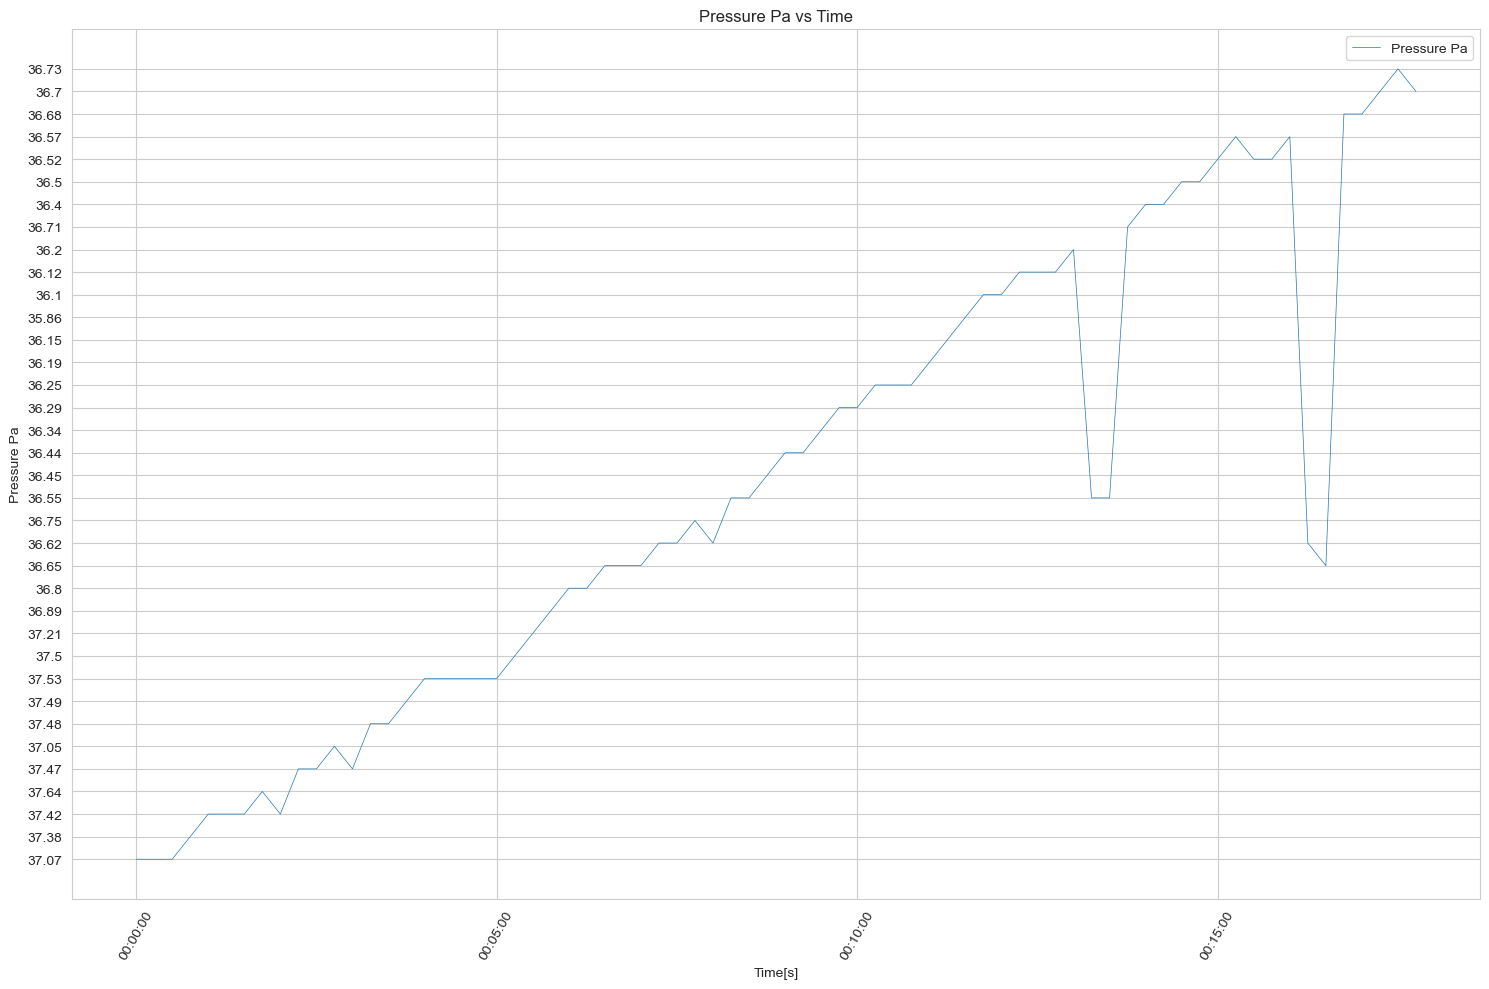

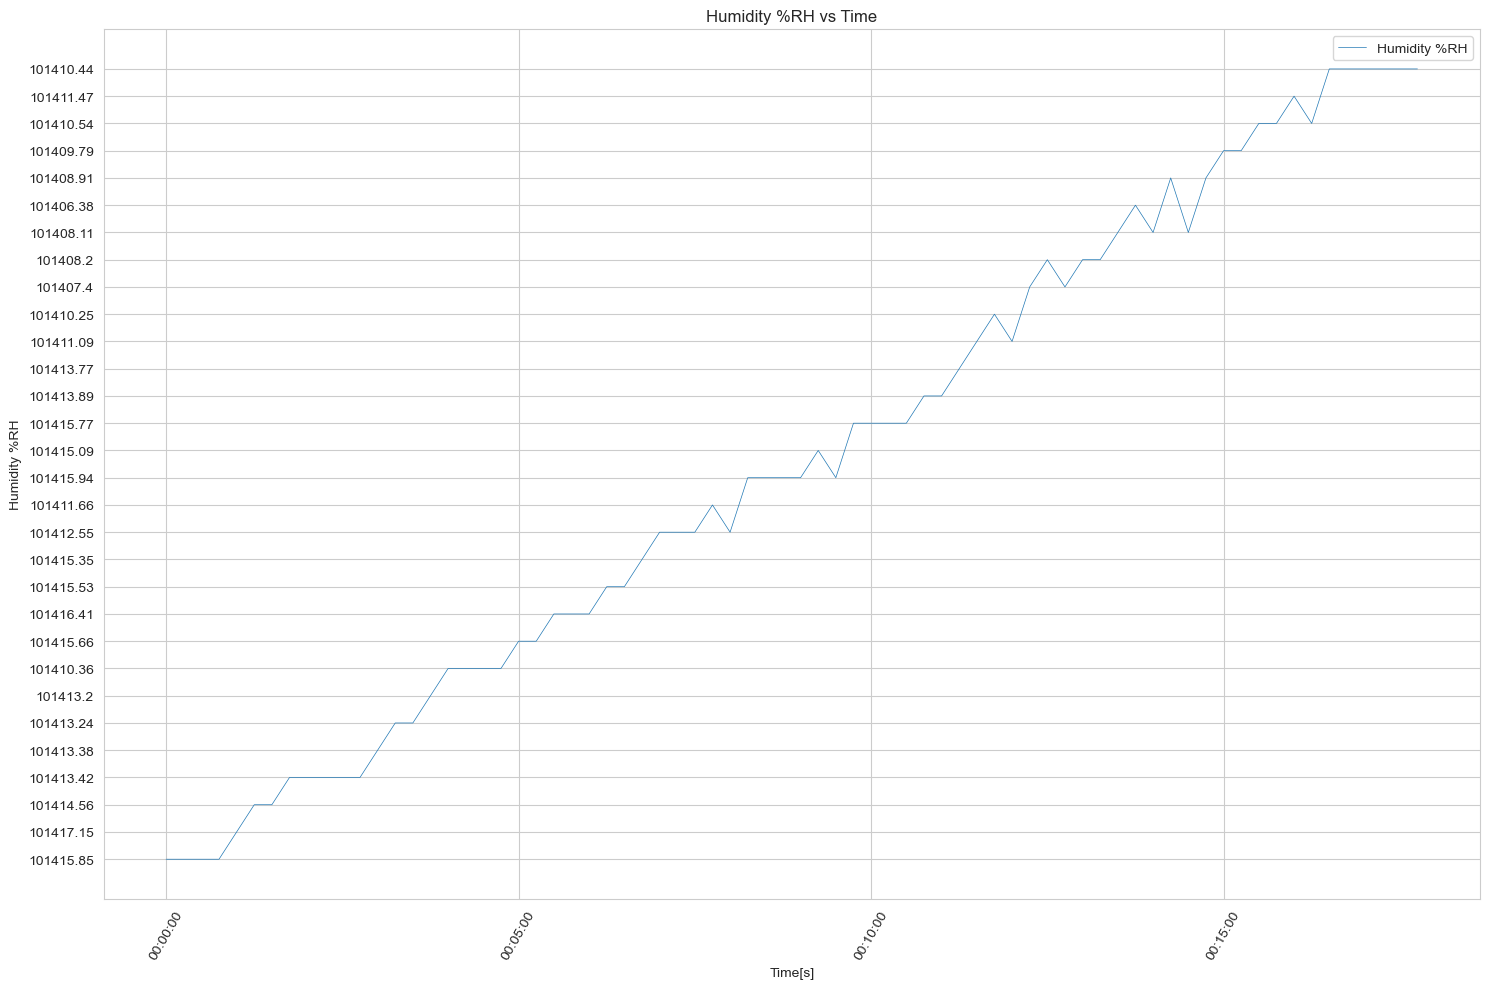

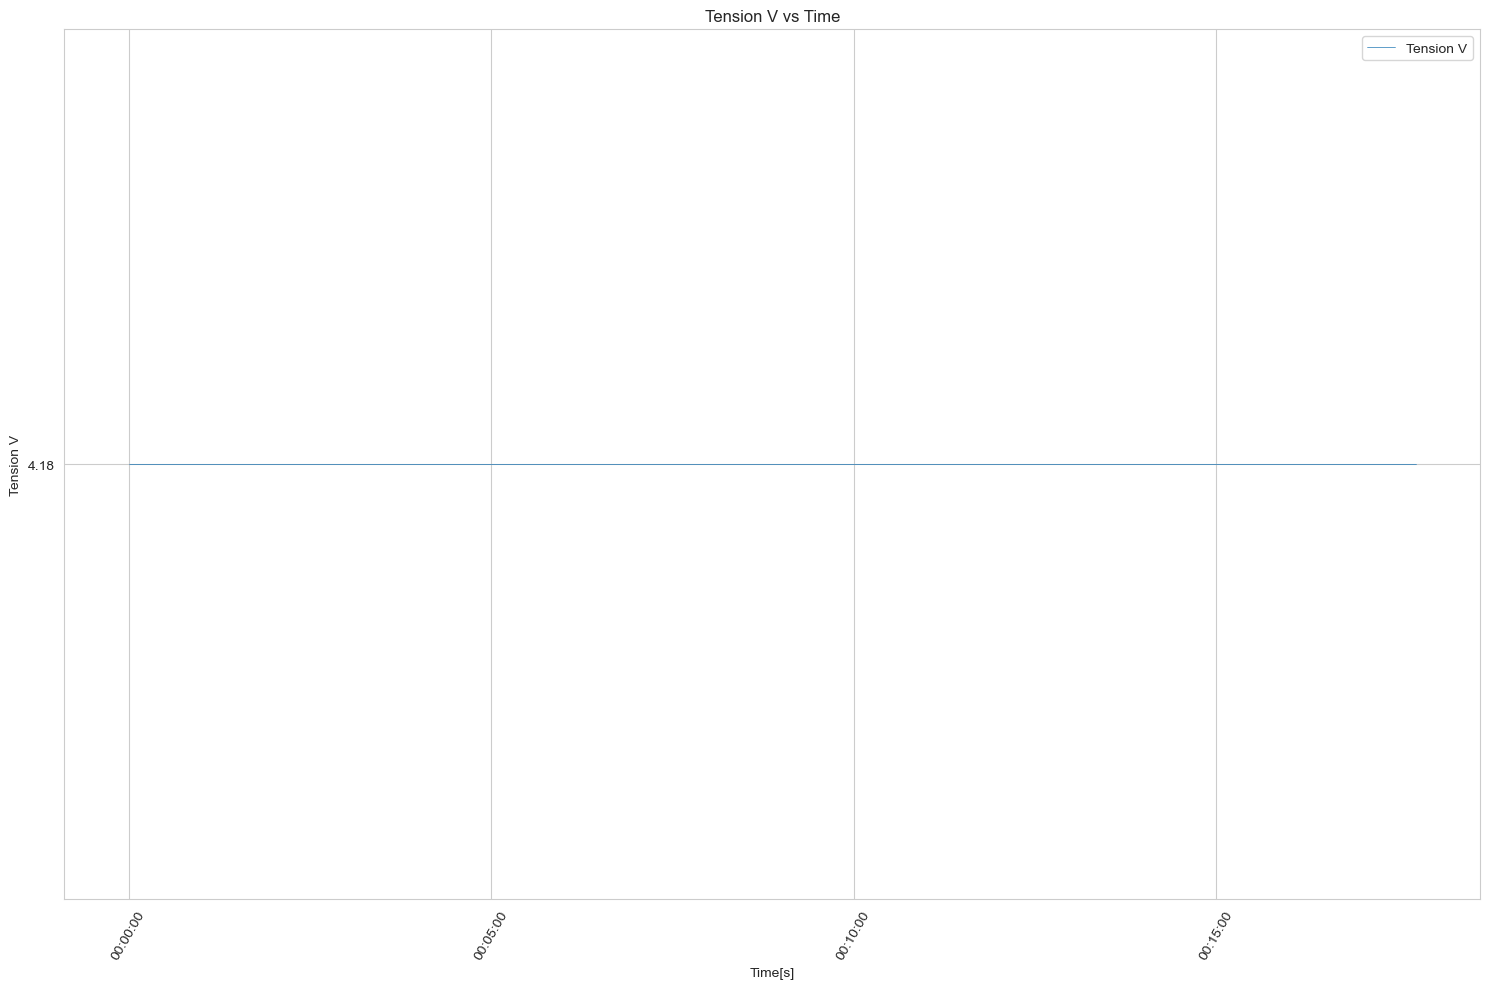

In [12]:
display_time_series(df, start=0, end=72, features=['GasSensor #1 V', 'Pressure Pa', 'Humidity %RH', 'Tension V'])

### Find a formula that converts values to AQI

In [12]:
# Formula